1. Загружаем сэмплы
2. Новые точки
3. Считаем для них MC оценки


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import torch

In [4]:
from tqdm import tqdm

In [5]:
from easydict import EasyDict as edict
args = {
    #'bnn_lr': 1e-3,
    'cv_lr': 1e-6,
    'n_cv_iter': 50,
    'batch_size' : 20000,
    'input_dim' : 784,
    'width' : 100,
    'depth' : 2,
    'output_dim' : 2,
    }

args = edict(args)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
import pickle
from copy import deepcopy

with open('drive/My Drive/saved_samples/mnist_weights/20_samples_seed-1.pkl', 'rb') as fp:
    samples = pickle.load(fp)
# with open('../../saved_samples/mnist_weights/30_samples_seed-1.pkl', 'rb') as fp:
#     samples = pickle.load(fp)

In [9]:
len(samples), len(samples[0][0])

(20, 124)

In [9]:
samples = [(x[0][::5], x[1]) for x in samples]

In [10]:
len(samples[0][0])

124

In [11]:
import sys
sys.path.append('drive/My Drive/control-variates')
# sys.path.append('..')
import control_variates
from control_variates.model import LogRegression
from mnist_utils import load_mnist_dataset
from control_variates.cv import PsyLinear, SteinCV, PsyConstVector, PsyMLP
from control_variates.cv_utils import state_dict_to_vec, compute_naive_variance
from control_variates.model import get_binary_prediction
import numpy as np
from control_variates.uncertainty_quantification import ClassificationUncertaintyMCMC
from control_variates.cv_utils import trapezoidal_kernel, SpectralVariance

In [12]:
train_dl, valid_dl = load_mnist_dataset('drive/My Drive/data/mnist/', args.batch_size, classes=[3, 5])
N_train = len(train_dl.dataset)

In [13]:
#_, valid_dl = load_mnist_dataset('drive/My Drive/data/mnist/', args.batch_size, classes=[4, 6])


In [14]:
trajectories = [[LogRegression(args.input_dim)
                 for j in range(len(samples[i][0]))]
                for i in range(len(samples))]

for i in range(len(samples)):
    for j in range(len(samples[i][0])):
        trajectories[i][j].load_state_dict(samples[i][0][j])

priors = [samples[i][1] for i in range(len(samples))]

In [15]:
len(samples[0])

2

In [16]:
len(trajectories)

20

In [17]:
# import random
# random.seed(42)

# traj, prior = samples[0]
# new_samples = []
# for _ in range(10):
#     new_samples.append((random.sample(traj, 15), prior))


# trajectories = [[LogRegression(args.input_dim)
#                  for j in range(len(new_samples[i][0]))]
#                 for i in range(len(new_samples))]

# for i in range(len(new_samples)):
#     for j in range(len(new_samples[i][0])):
#         trajectories[i][j].load_state_dict(new_samples[i][0][j])

# priors = [new_samples[i][1] for i in range(len(new_samples))]

# squeezed_weights = [[state_dict_to_vec(new_samples[i][0][j]) 
#                      for j in range(len(new_samples[i][0]))]
#                     for i in range(len(new_samples))]

In [18]:
x_new, y_new = next(iter(valid_dl))
train_x, train_y = next(iter(train_dl))

Фитим ncv

In [19]:
psy_input_dim = 1570

In [20]:
def centr_regularizer(ncv, models, x, ll_div=None):
    return (ncv(models, x, ll_div).mean(0))**2

In [21]:
from control_variates.cv_utils import compute_log_likelihood, compute_concat_gradient

def compute_ll_div(models, train_x, train_y, N_train, priors=None):
    for model in models:
        model.zero_grad()
    log_likelihoods = [(compute_log_likelihood(train_x, train_y, model) * N_train).backward() for model in models]
    ll_div = torch.stack([compute_concat_gradient(model, priors) for model in models])
    return ll_div


In [22]:
from torch.nn import functional as F

for i, x in enumerate(x_new[y_new == 1.0]):
    predictions = [F.softmax(model(x), -1) for model in trajectories[0]]
    var = torch.tensor([x[:, 1] for x in predictions]).std()**2
    if var > 1e-3:
        break

print(var, i)

tensor(0.0010) 289


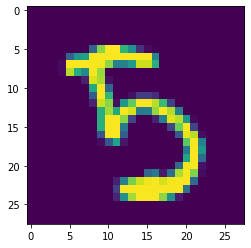

In [23]:
plt.imshow(x[0])

In [24]:
torch.tensor([x[:, 1] for x in predictions]).std()**2

tensor(0.0010)

In [25]:
#x = (x_new[y_new == 1.0])[[0]]

In [26]:
len(trajectories[0])

124

{'boxes': [<matplotlib.lines.Line2D at 0x7fdb8b8bd358>],
 'caps': [<matplotlib.lines.Line2D at 0x7fdb8b8bdd68>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdb8b8cc828>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fdb8b8cc4a8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fdb8b8bd668>,
  <matplotlib.lines.Line2D at 0x7fdb8b8bd9e8>]}

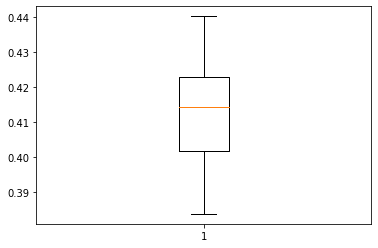

In [27]:
l = [get_binary_prediction(models, x, [0,1]).mean().item() for models in trajectories]

plt.boxplot(l)

In [30]:
ncv_s = []

psy_input_dim = 1570 #squeezed_weights[0][0].shape[0]

for models, pr in zip(trajectories, priors):
    psy_model = PsyConstVector(psy_input_dim)
    #psy_model = PsyLinear(psy_input_dim)
    #psy_model = PsyMLP(psy_input_dim, 50, 1)
    psy_model.init_zero()
    psy_model.to(device)

    neural_control_variate = SteinCV(psy_model, train_x, train_y, pr, N_train)

    ncv_optimizer = torch.optim.Adam(psy_model.parameters(), lr=args.cv_lr, weight_decay=0.0) #1e-4)
    uncertainty_quant = ClassificationUncertaintyMCMC(models, neural_control_variate)

    train_x, train_y = next(iter(train_dl))
    ll_div = compute_ll_div(models, train_x, train_y, N_train, priors=priors)

    function_f = lambda model, x: get_binary_prediction(model, x, classes=[0, 1])
    history = [] 
    #x = (x_new[y_new == 1.0])[[0]]

    for it in tqdm(range(args.n_cv_iter)):
        ncv_optimizer.zero_grad()
        mc_variance, no_cv_variance = compute_naive_variance(function_f, neural_control_variate, models, x, ll_div)
        #print(no_cv_variance)
        history.append(mc_variance.mean().item())
        (mc_variance + centr_regularizer(neural_control_variate, models, x, ll_div)).mean().backward()
        #mc_variance.mean().backward()
        ncv_optimizer.step()
    ncv_s.append(neural_control_variate)
    print(mc_variance.mean().item(), no_cv_variance.mean().item())

    print(neural_control_variate(models, x, ll_div).mean())

100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


3.26859371853061e-05 0.0010014163563027978
tensor(0.0001, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


4.283447560737841e-05 0.0007941573858261108
tensor(0.0003, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


3.2153850042959675e-05 0.0004340090381447226
tensor(-0.0004, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.60it/s]


1.4756945347471628e-05 0.0006979415193200111
tensor(0.0006, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.58it/s]


2.2298965632217005e-05 0.0010627974988892674
tensor(0.0005, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.57it/s]


4.122795144212432e-05 0.0007258145487867296
tensor(0.0005, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


1.5514911865466274e-05 0.0006842594593763351
tensor(0.0005, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


1.2023774615954608e-05 0.0005017629009671509
tensor(-3.4174e-05, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.43it/s]


4.491728395805694e-05 0.0010489575797691941
tensor(5.0722e-06, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]


3.113747152383439e-05 0.0006713459733873606
tensor(0.0003, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


4.789166268892586e-05 0.0007849272806197405
tensor(0.0002, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


4.100208752788603e-05 0.0009423907031305134
tensor(0.0003, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.41it/s]


1.850203625508584e-05 0.0005774481105618179
tensor(-3.3157e-05, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


2.83149529423099e-05 0.0008710506372153759
tensor(0.0003, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.60it/s]


2.771841718640644e-05 0.0006390640046447515
tensor(0.0002, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.21it/s]


4.8798112402437255e-05 0.0009883990278467536
tensor(3.7551e-05, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


2.5398374418728054e-05 0.0009489463409408927
tensor(0.0006, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


4.565286508295685e-05 0.0007942055817693472
tensor(0.0005, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 10.75it/s]


2.184911136282608e-05 0.000706312304828316
tensor(0.0004, grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [00:04<00:00, 11.12it/s]

4.705242463387549e-05 0.0009340790566056967
tensor(4.5124e-05, grad_fn=<MeanBackward0>)


In [31]:
psy_weights = [deepcopy(ncv.psy_model.state_dict()) for ncv in ncv_s]

In [32]:
psy_weights[0]

OrderedDict([('param',
              tensor([ 4.5082e-06,  4.5082e-06,  4.5082e-06,  ..., -4.5082e-06,
                      -4.5082e-06,  4.5082e-06]))])

In [33]:
with open('drive/My Drive/data/psy_weights.pckl', 'wb') as fp:
    pickle.dump(psy_weights, fp)

In [ ]:
# import pickle
# with open('../data/psy_weights.pckl', 'rb') as fp:
#     psy_weights = pickle.load(fp)

In [ ]:
len(psy_weights)

In [ ]:
ncv_s2 = []
for models, pr in zip(trajectories, priors):
    psy_model = PsyConstVector(psy_input_dim)
    psy_model.init_zero()
    psy_model.to(device)

    neural_control_variate = SteinCV(psy_model, train_x, train_y, priors, N_train)
    function_f = lambda model, x: get_binary_prediction(model, x, classes=[0, 1])

    function_h = lambda model, x: function_f(model, x) - neural_control_variate(model, x)

    window_lag_f = trapezoidal_kernel
    truncation_point = 3 #len(models) 
    spectral_loss = SpectralVariance(function_h, models, window_lag_f, truncation_point)
    no_cv_loss = SpectralVariance(function_f, models, window_lag_f, truncation_point)

    train_x, train_y = next(iter(train_dl))
    ll_div = compute_ll_div(models, train_x, train_y, N_train, priors=priors)

    ncv_optimizer = torch.optim.Adam(psy_model.parameters(), lr=args.cv_lr, weight_decay=0.0) #1e-4)

    history = [] 
    x = x_new[:10]
    #fig = plt.figure()

    no_cv_variance = no_cv_loss(x)

    data_iter = iter(train_dl)
    for it in tqdm(range(args.n_cv_iter)):
        try:
            train_x, train_y = next(data_iter)
        except:
            data_iter = iter(train_dl)
            train_x, train_y = next(data_iter)
        neural_control_variate.train_x = train_x
        neural_control_variate.train_y = train_y
        ncv_optimizer.zero_grad()
        mc_variance = spectral_loss(x)
        history.append(mc_variance.mean().item())
        (mc_variance + 1e-3 * centr_regularizer(neural_control_variate, models, x)).backward()
        ncv_optimizer.step()
    ncv_s2.append(neural_control_variate)
    print(mc_variance.mean().item(), no_cv_variance.mean().item())
    print(neural_control_variate(models, x).mean())
    # plt.plot(np.arange(it+1), history)
    # plt.axhline(y=no_cv_variance.mean(), color='r', linestyle='-')
    # plt.xlim(0, args.n_cv_iter)
    # plt.show()

In [ ]:
psy_weights2 = [deepcopy(ncv.psy_model.state_dict()) for ncv in ncv_s2]

In [ ]:
with open('../data/psy_weights2.pckl', 'wb') as fp:
    pickle.dump(psy_weights2, fp)